 # Multi-Task Face Analysis: Age and Gender Prediction



 In this notebook, we'll implement a deep learning model for simultaneously predicting age and gender from facial images, with a focus on bias mitigation and ethical considerations.



 ## Contents

 1. Setup and Imports

 2. Data Loading and Preprocessing

 3. Model Architecture

 4. Training Pipeline with Bias Mitigation

 5. Evaluation and Analysis

 6. Ethical Considerations

 7. Results and Recommendations

 ## 1. Setup and Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from lime import lime_image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from skimage.segmentation import mark_boundaries
import torch.nn.functional as F

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


 ## 2. Data Loading and Preprocessing

In [2]:
def parse_filepath(filepath):
    """Parse UTKFace filepath to extract age, gender, and race information"""
    try:
        filename = filepath.stem
        age, gender, race, _ = filename.split('_')
        return {
            'filepath': str(filepath),
            'age': int(age),
            'gender': int(gender),  # 0: male, 1: female
            'race': int(race)
        }
    except:
        return None

def create_dataset_df(data_dir):
    """Create a DataFrame with image metadata"""
    image_paths = Path(data_dir).glob('*.jpg')
    records = []
    for filepath in image_paths:
        record = parse_filepath(filepath)
        if record:
            records.append(record)
    return pd.DataFrame(records)


In [ ]:
DATA_DIR = r"C:\Users\kresi\OneDrive\Desktop\Turing college\DL\Age Gender\data\UTKFace"
df = create_dataset_df(DATA_DIR)
print("Dataset Overview:")
print(df.info())


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  23705 non-null  object
 1   age       23705 non-null  int64 
 2   gender    23705 non-null  int64 
 3   race      23705 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 740.9+ KB
None


In [ ]:
class FaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filepath']
        image = Image.open(img_path)
        
        if image.mode != 'RGB':
            image = image.convert('RGB')
            
        age = self.df.iloc[idx]['age']
        gender = self.df.iloc[idx]['gender']
        
        if self.transform:
            image = self.transform(image)
            
        age = torch.tensor(age/116.0, dtype=torch.float32)
        gender = torch.tensor(gender, dtype=torch.long)
        
        return image, age, gender

def create_balanced_sampler(dataset):
    """Create a sampler that balances age groups and gender"""
    df = dataset.df.reset_index(drop=True)  # Reset index to ensure alignment
    
    df['age_group'] = pd.cut(df['age'], 
                            bins=[0, 20, 40, 60, 80, 120],
                            labels=['0-20', '21-40', '41-60', '61-80', '80+'])
    
    weights = np.ones(len(df))
    
    age_group_counts = df['age_group'].value_counts()
    max_age_count = age_group_counts.max()
    
    for group in age_group_counts.index:
        group_indices = df.index[df['age_group'] == group]
        weights[group_indices] *= max_age_count / age_group_counts[group]
    
    gender_counts = df['gender'].value_counts()
    max_gender_count = gender_counts.max()
    
    for gender in gender_counts.index:
        gender_indices = df.index[df['gender'] == gender]
        weights[gender_indices] *= max_gender_count / gender_counts[gender]
    
    weights = weights / weights.sum()
    
    return torch.utils.data.WeightedRandomSampler(
        weights=torch.FloatTensor(weights),
        num_samples=len(weights),
        replacement=True
    )


 ## 3. Model Architecture

In [ ]:
class MultiTaskFaceNet(nn.Module):
    def __init__(self):
        super(MultiTaskFaceNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(512),
        )
        
        self.age_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
        self.gender_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )
        
    def forward(self, x):
        features = self.features(x)
        age_out = self.age_head(features)
        gender_out = self.gender_head(features)
        return age_out, gender_out


 ## 4. Training Pipeline with Bias Mitigation

In [ ]:
class WeightedMultiTaskLoss(nn.Module):
    def __init__(self):
        super(WeightedMultiTaskLoss, self).__init__()
        self.age_criterion = nn.MSELoss(reduction='none')
        self.gender_criterion = nn.CrossEntropyLoss(reduction='none')
        
    def forward(self, age_pred, age_true, gender_pred, gender_true):
        age_loss = self.age_criterion(age_pred.squeeze(), age_true)
        gender_loss = self.gender_criterion(gender_pred, gender_true)
        
        age_weights = torch.ones_like(age_true)
        age_weights[age_true > 0.6] = 2.0
        
        weighted_age_loss = (age_loss * age_weights).mean()
        weighted_gender_loss = gender_loss.mean()
        
        return weighted_age_loss + weighted_gender_loss

def train_model(model, train_loader, val_loader, criterion, device, num_epochs=30):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for images, ages, genders in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            ages = ages.to(device)
            genders = genders.to(device)
            
            optimizer.zero_grad()
            
            age_pred, gender_pred = model(images)
            loss = criterion(age_pred, ages, gender_pred, genders)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for images, ages, genders in val_loader:
                images = images.to(device)
                ages = ages.to(device)
                genders = genders.to(device)
                
                age_pred, gender_pred = model(images)
                loss = criterion(age_pred, ages, gender_pred, genders)
                
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Val Loss: {val_loss:.4f}')
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    return train_losses, val_losses


 ## 5. Evaluation and Analysis

In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    age_errors = []
    gender_errors = []
    predictions = []
    
    with torch.no_grad():
        for images, ages, genders in test_loader:
            images = images.to(device)
            ages = ages.to(device)
            genders = genders.to(device)
            
            age_pred, gender_pred = model(images)
            
            age_pred = age_pred.squeeze().cpu() * 116.0  # Denormalize age
            gender_pred = torch.argmax(gender_pred, dim=1).cpu()
            
            batch_results = {
                'age_true': ages.cpu() * 116.0,
                'age_pred': age_pred,
                'gender_true': genders.cpu(),
                'gender_pred': gender_pred
            }
            predictions.append(batch_results)
            
            age_errors.extend(torch.abs(age_pred - ages.cpu() * 116.0).numpy())
            gender_errors.extend((gender_pred != genders.cpu()).numpy())
    
    mae_age = np.mean(age_errors)
    gender_accuracy = 1 - np.mean(gender_errors)
    
    return mae_age, gender_accuracy, predictions

def analyze_bias(predictions, df_test):
    """Analyze model bias across different demographics"""
    results = []
    
    for batch in predictions:
        batch_results = pd.DataFrame({
            'age_true': batch['age_true'],
            'age_pred': batch['age_pred'],
            'gender_true': batch['gender_true'],
            'gender_pred': batch['gender_pred']
        })
        results.append(batch_results)
    
    results_df = pd.concat(results, ignore_index=True)
    results_df = pd.concat([results_df, df_test.reset_index(drop=True)], axis=1)
    
    age_groups = pd.cut(results_df['age_true'], 
                       bins=[0, 20, 40, 60, 80, 120],
                       labels=['0-20', '21-40', '41-60', '61-80', '80+'])
    
    age_bias = results_df.groupby(age_groups).agg({
        'age_true': 'count',
        'age_pred': lambda x: np.mean(np.abs(x - results_df.loc[x.index, 'age_true'])),
        'gender_pred': lambda x: np.mean(x == results_df.loc[x.index, 'gender_true'])
    }).round(2)
    
    gender_bias = results_df.groupby('gender_true').agg({
        'age_true': 'count',
        'age_pred': lambda x: np.mean(np.abs(x - results_df.loc[x.index, 'age_true'])),
        'gender_pred': lambda x: np.mean(x == results_df.loc[x.index, 'gender_true'])
    }).round(2)
    
    return age_bias, gender_bias

def analyze_feature_importance(model, test_loader, transform, num_samples=5):
    """Analyze feature importance across different demographics"""
    model.eval()
    
    sample_images = []
    sample_labels = []
    
    for images, ages, genders in test_loader:
        sample_images.extend(images[:num_samples])
        sample_labels.extend(zip(ages[:num_samples], genders[:num_samples]))
        break
    
    def batch_predict(images):
        """Wrapper for model prediction that returns probabilities"""
        batch = torch.stack([
            transform(Image.fromarray(img.astype('uint8'))) 
            for img in images
        ]).to(device)
        
        with torch.no_grad():
            age_pred, gender_pred = model(batch)
            gender_probs = F.softmax(gender_pred, dim=1)
            return gender_probs.cpu().numpy()  # Only use gender for LIME visualization
    
    for img, (age, gender) in zip(sample_images, sample_labels):
        img_np = img.permute(1, 2, 0).numpy()
        img_np = (img_np * 255).astype('uint8')
        
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(
            img_np,
            batch_predict,
            top_labels=2,
            hide_color=0,
            num_samples=100
        )
        
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        
        axs[0].imshow(img_np)
        axs[0].set_title(f'Original\nAge: {age*116:.1f}, Gender: {"F" if gender else "M"}')
        axs[0].axis('off')
        
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],  # Use first label
            positive_only=True,
            num_features=5,
            hide_rest=True
        )
        axs[1].imshow(mark_boundaries(temp, mask))
        axs[1].set_title('Features for Gender Prediction')
        axs[1].axis('off')
        
        plt.tight_layout()
        plt.show()

 ## 6. Main Execution Pipeline

In [ ]:
def main():
    df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
    df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)
    
    train_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = FaceDataset(df_train, transform=train_transform)
    val_dataset = FaceDataset(df_val, transform=val_transform)
    test_dataset = FaceDataset(df_test, transform=val_transform)
    
    balanced_sampler = create_balanced_sampler(train_dataset)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=32, 
        sampler=balanced_sampler,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=32, 
        shuffle=False, 
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=32, 
        shuffle=False, 
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    model = MultiTaskFaceNet().to(device)
    criterion = WeightedMultiTaskLoss()
    
    print("Starting training...")
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, device)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    print("\nEvaluating model...")
    mae_age, gender_accuracy, predictions = evaluate_model(model, test_loader, device)
    print(f"Mean Absolute Error (Age): {mae_age:.2f} years")
    print(f"Gender Accuracy: {gender_accuracy:.2%}")
    
    print("\nAnalyzing demographic bias...")
    age_bias, gender_bias = analyze_bias(predictions, df_test)
    print("\nAge Group Bias Analysis:")
    print(age_bias)
    print("\nGender Bias Analysis:")
    print(gender_bias)
    
    print("\nAnalyzing feature importance...")
    analyze_feature_importance(model, test_loader, val_transform)
    
    return model, mae_age, gender_accuracy, age_bias, gender_bias


 ## 7. Run Complete Analysis

Starting training...


Epoch 1/30: 100%|██████████| 519/519 [00:59<00:00,  8.66it/s]


Epoch 1/30:
Train Loss: 0.7089
Val Loss: 0.6270


Epoch 2/30: 100%|██████████| 519/519 [01:03<00:00,  8.11it/s]


Epoch 2/30:
Train Loss: 0.5901
Val Loss: 0.4341


Epoch 3/30: 100%|██████████| 519/519 [01:03<00:00,  8.13it/s]


Epoch 3/30:
Train Loss: 0.4628
Val Loss: 0.3737


Epoch 4/30: 100%|██████████| 519/519 [01:00<00:00,  8.61it/s]


Epoch 4/30:
Train Loss: 0.3908
Val Loss: 0.3527


Epoch 5/30: 100%|██████████| 519/519 [01:01<00:00,  8.46it/s]


Epoch 5/30:
Train Loss: 0.3424
Val Loss: 0.3549


Epoch 6/30: 100%|██████████| 519/519 [01:01<00:00,  8.49it/s]


Epoch 6/30:
Train Loss: 0.2995
Val Loss: 0.2952


Epoch 7/30: 100%|██████████| 519/519 [01:00<00:00,  8.53it/s]


Epoch 7/30:
Train Loss: 0.2675
Val Loss: 0.2759


Epoch 8/30: 100%|██████████| 519/519 [01:01<00:00,  8.48it/s]


Epoch 8/30:
Train Loss: 0.2417
Val Loss: 0.2578


Epoch 9/30: 100%|██████████| 519/519 [01:00<00:00,  8.55it/s]


Epoch 9/30:
Train Loss: 0.2281
Val Loss: 0.2626


Epoch 10/30: 100%|██████████| 519/519 [01:00<00:00,  8.58it/s]


Epoch 10/30:
Train Loss: 0.2087
Val Loss: 0.2870


Epoch 11/30: 100%|██████████| 519/519 [01:00<00:00,  8.61it/s]


Epoch 11/30:
Train Loss: 0.2060
Val Loss: 0.3067


Epoch 12/30: 100%|██████████| 519/519 [01:00<00:00,  8.59it/s]


Epoch 12/30:
Train Loss: 0.1900
Val Loss: 0.2939


Epoch 13/30: 100%|██████████| 519/519 [00:59<00:00,  8.78it/s]


Epoch 13/30:
Train Loss: 0.1583
Val Loss: 0.2283


Epoch 14/30: 100%|██████████| 519/519 [00:56<00:00,  9.23it/s]


Epoch 14/30:
Train Loss: 0.1524
Val Loss: 0.2316


Epoch 15/30: 100%|██████████| 519/519 [00:55<00:00,  9.32it/s]


Epoch 15/30:
Train Loss: 0.1473
Val Loss: 0.2290


Epoch 16/30: 100%|██████████| 519/519 [01:00<00:00,  8.61it/s]


Epoch 16/30:
Train Loss: 0.1399
Val Loss: 0.2302


Epoch 17/30: 100%|██████████| 519/519 [01:01<00:00,  8.48it/s]


Epoch 17/30:
Train Loss: 0.1323
Val Loss: 0.2233


Epoch 18/30: 100%|██████████| 519/519 [01:06<00:00,  7.76it/s]


Epoch 18/30:
Train Loss: 0.1296
Val Loss: 0.2260


Epoch 19/30: 100%|██████████| 519/519 [01:04<00:00,  8.01it/s]


Epoch 19/30:
Train Loss: 0.1357
Val Loss: 0.2237


Epoch 20/30: 100%|██████████| 519/519 [01:07<00:00,  7.72it/s]


Epoch 20/30:
Train Loss: 0.1275
Val Loss: 0.2251


Epoch 21/30: 100%|██████████| 519/519 [01:02<00:00,  8.37it/s]


Epoch 21/30:
Train Loss: 0.1199
Val Loss: 0.2329


Epoch 22/30: 100%|██████████| 519/519 [01:01<00:00,  8.39it/s]


Epoch 22/30:
Train Loss: 0.1223
Val Loss: 0.2308


Epoch 23/30: 100%|██████████| 519/519 [01:01<00:00,  8.49it/s]


Epoch 23/30:
Train Loss: 0.1190
Val Loss: 0.2273


Epoch 24/30: 100%|██████████| 519/519 [01:00<00:00,  8.61it/s]


Epoch 24/30:
Train Loss: 0.1194
Val Loss: 0.2287


Epoch 25/30: 100%|██████████| 519/519 [01:00<00:00,  8.53it/s]


Epoch 25/30:
Train Loss: 0.1219
Val Loss: 0.2269


Epoch 26/30: 100%|██████████| 519/519 [00:59<00:00,  8.66it/s]


Epoch 26/30:
Train Loss: 0.1175
Val Loss: 0.2265


Epoch 27/30: 100%|██████████| 519/519 [00:56<00:00,  9.20it/s]


Epoch 27/30:
Train Loss: 0.1187
Val Loss: 0.2281


Epoch 28/30: 100%|██████████| 519/519 [00:53<00:00,  9.66it/s]


Epoch 28/30:
Train Loss: 0.1171
Val Loss: 0.2262


Epoch 29/30: 100%|██████████| 519/519 [01:01<00:00,  8.47it/s]


Epoch 29/30:
Train Loss: 0.1199
Val Loss: 0.2262


Epoch 30/30: 100%|██████████| 519/519 [00:58<00:00,  8.90it/s]


Epoch 30/30:
Train Loss: 0.1199
Val Loss: 0.2272


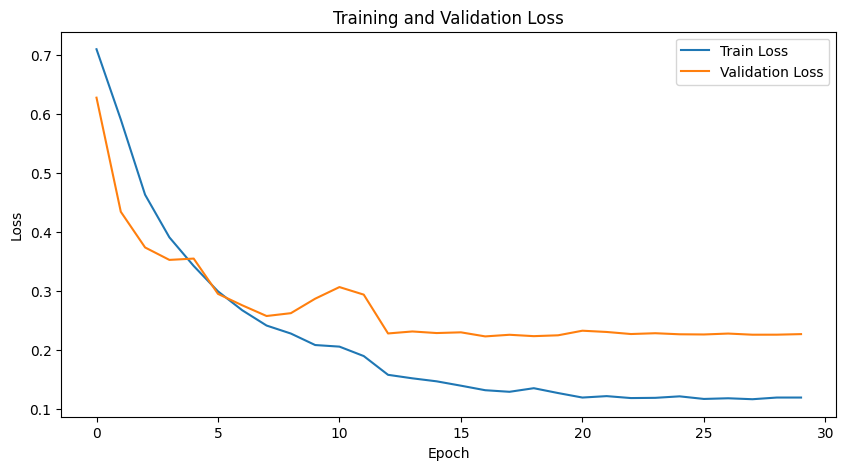


Evaluating model...
Mean Absolute Error (Age): 7.43 years
Gender Accuracy: 91.59%

Analyzing demographic bias...

Age Group Bias Analysis:
          age_true  age_pred  gender_pred
age_true                                 
0-20           731      5.13         0.77
21-40         1794      7.54         0.95
41-60          658      8.35         0.98
61-80          288      9.39         0.94
80+             85     11.19         0.92

Gender Bias Analysis:
             age_true  age_pred  gender_pred
gender_true                                 
0                1892      7.46         0.91
1                1664      7.41         0.93

Analyzing feature importance...


C:\Users\kresi\AppData\Local\Temp\ipykernel_17412\2290713221.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_bias = results_df.groupby(age_groups).agg({


  0%|          | 0/100 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


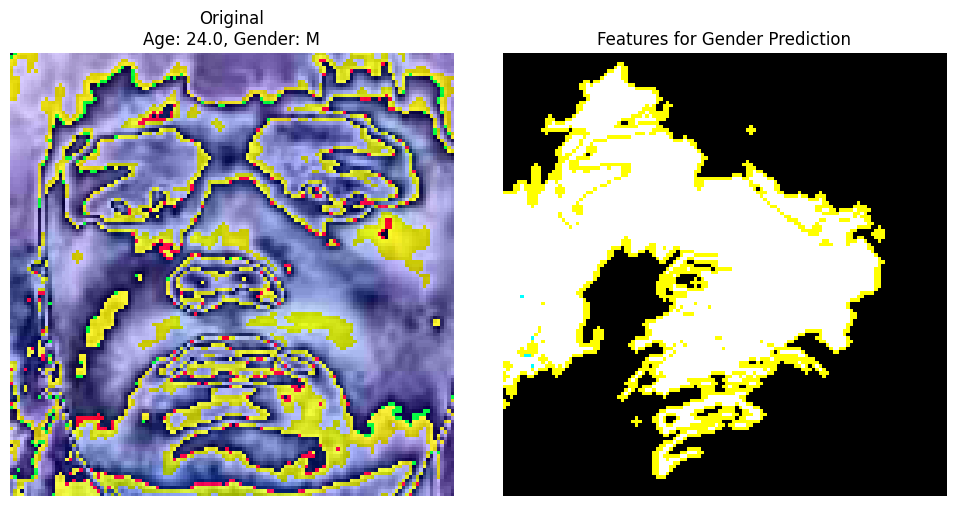

  0%|          | 0/100 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


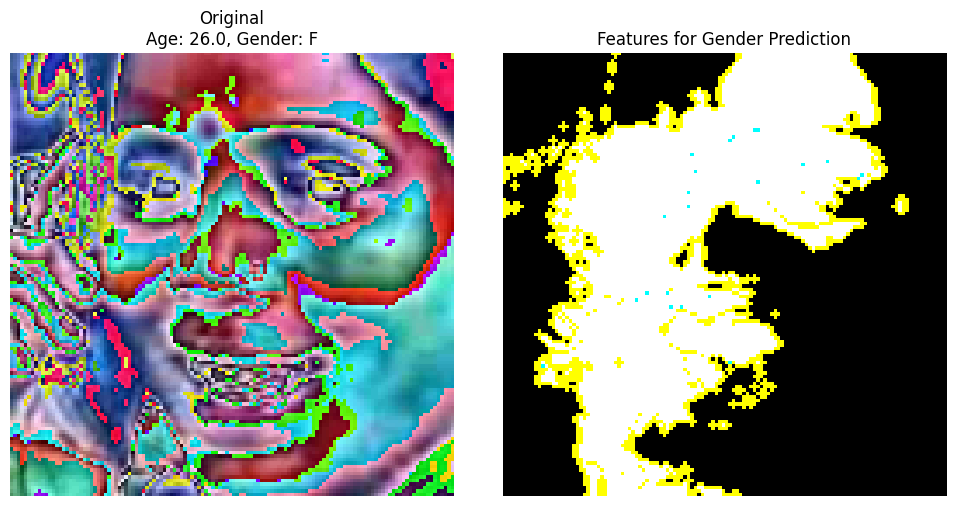

  0%|          | 0/100 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


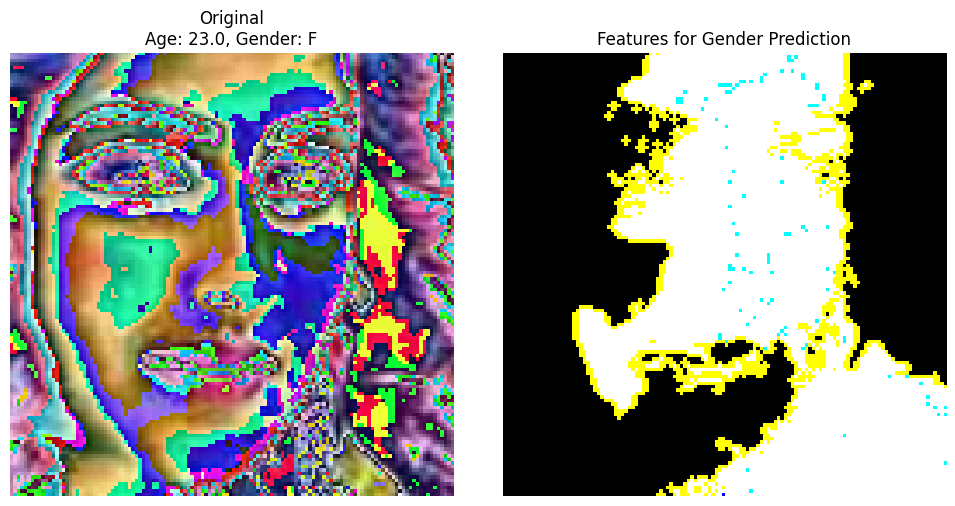

  0%|          | 0/100 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


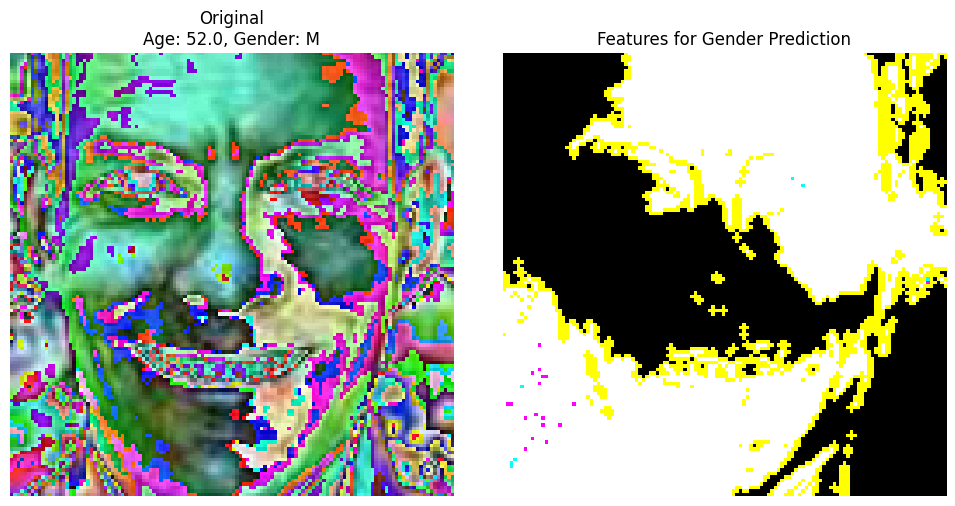

  0%|          | 0/100 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


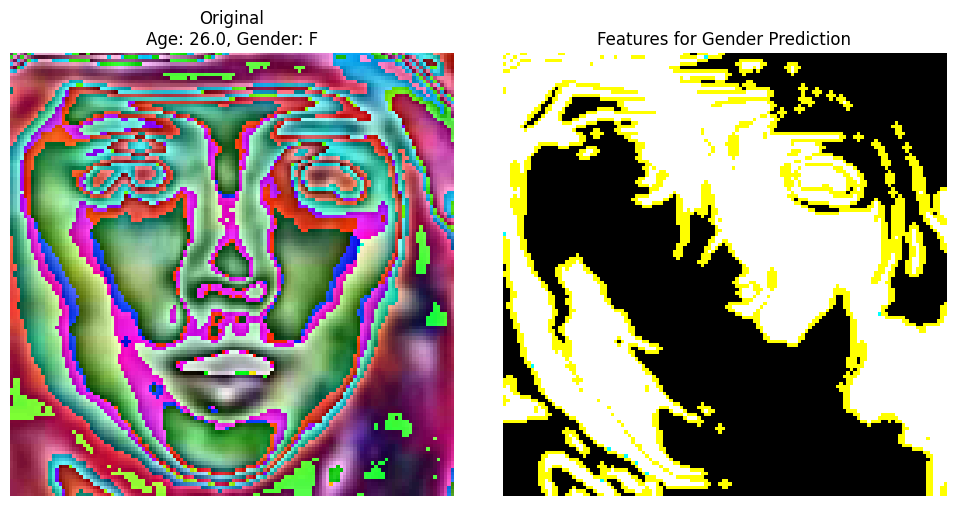

In [9]:
if __name__ == "__main__":
    model, mae_age, gender_accuracy, age_bias, gender_bias = main()


 ## 8. Results Analysis and Visualization

In [12]:
def plot_detailed_results(age_bias, gender_bias):
    """Create detailed visualizations of model performance"""
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 10))
    
    # 1. Age Error Distribution
    plt.subplot(2, 2, 1)
    age_mae = age_bias['age_pred']
    plt.bar(age_bias.index, age_mae, color='skyblue')
    plt.title('Mean Absolute Error by Age Group', pad=10, fontsize=12)
    plt.xlabel('Age Group', fontsize=10)
    plt.ylabel('MAE (years)', fontsize=10)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 2. Gender Accuracy by Age Group
    plt.subplot(2, 2, 2)
    gender_acc = age_bias['gender_pred'] * 100
    plt.bar(age_bias.index, gender_acc, color='lightgreen')
    plt.title('Gender Prediction Accuracy by Age Group', pad=10, fontsize=12)
    plt.xlabel('Age Group', fontsize=10)
    plt.ylabel('Accuracy (%)', fontsize=10)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 3. Sample Distribution
    plt.subplot(2, 2, 3)
    sample_counts = age_bias['age_true']
    plt.bar(age_bias.index, sample_counts, color='salmon')
    plt.title('Sample Distribution Across Age Groups', pad=10, fontsize=12)
    plt.xlabel('Age Group', fontsize=10)
    plt.ylabel('Number of Samples', fontsize=10)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 4. Gender-specific Age Prediction Error
    plt.subplot(2, 2, 4)
    gender_mae = gender_bias['age_pred']
    plt.bar(['Male', 'Female'], gender_mae, color='plum')
    plt.title('Age Prediction Error by Gender', pad=10, fontsize=12)
    plt.xlabel('Gender', fontsize=10)
    plt.ylabel('MAE (years)', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # Print numerical results
    print("\nDetailed Performance Metrics:")
    print("\nAge Prediction MAE by Age Group:")
    print(age_mae)
    print("\nGender Prediction Accuracy by Age Group:")
    print(gender_acc)
    print("\nSample Distribution:")
    print(sample_counts)
    print("\nAge Prediction MAE by Gender:")
    print(gender_mae)

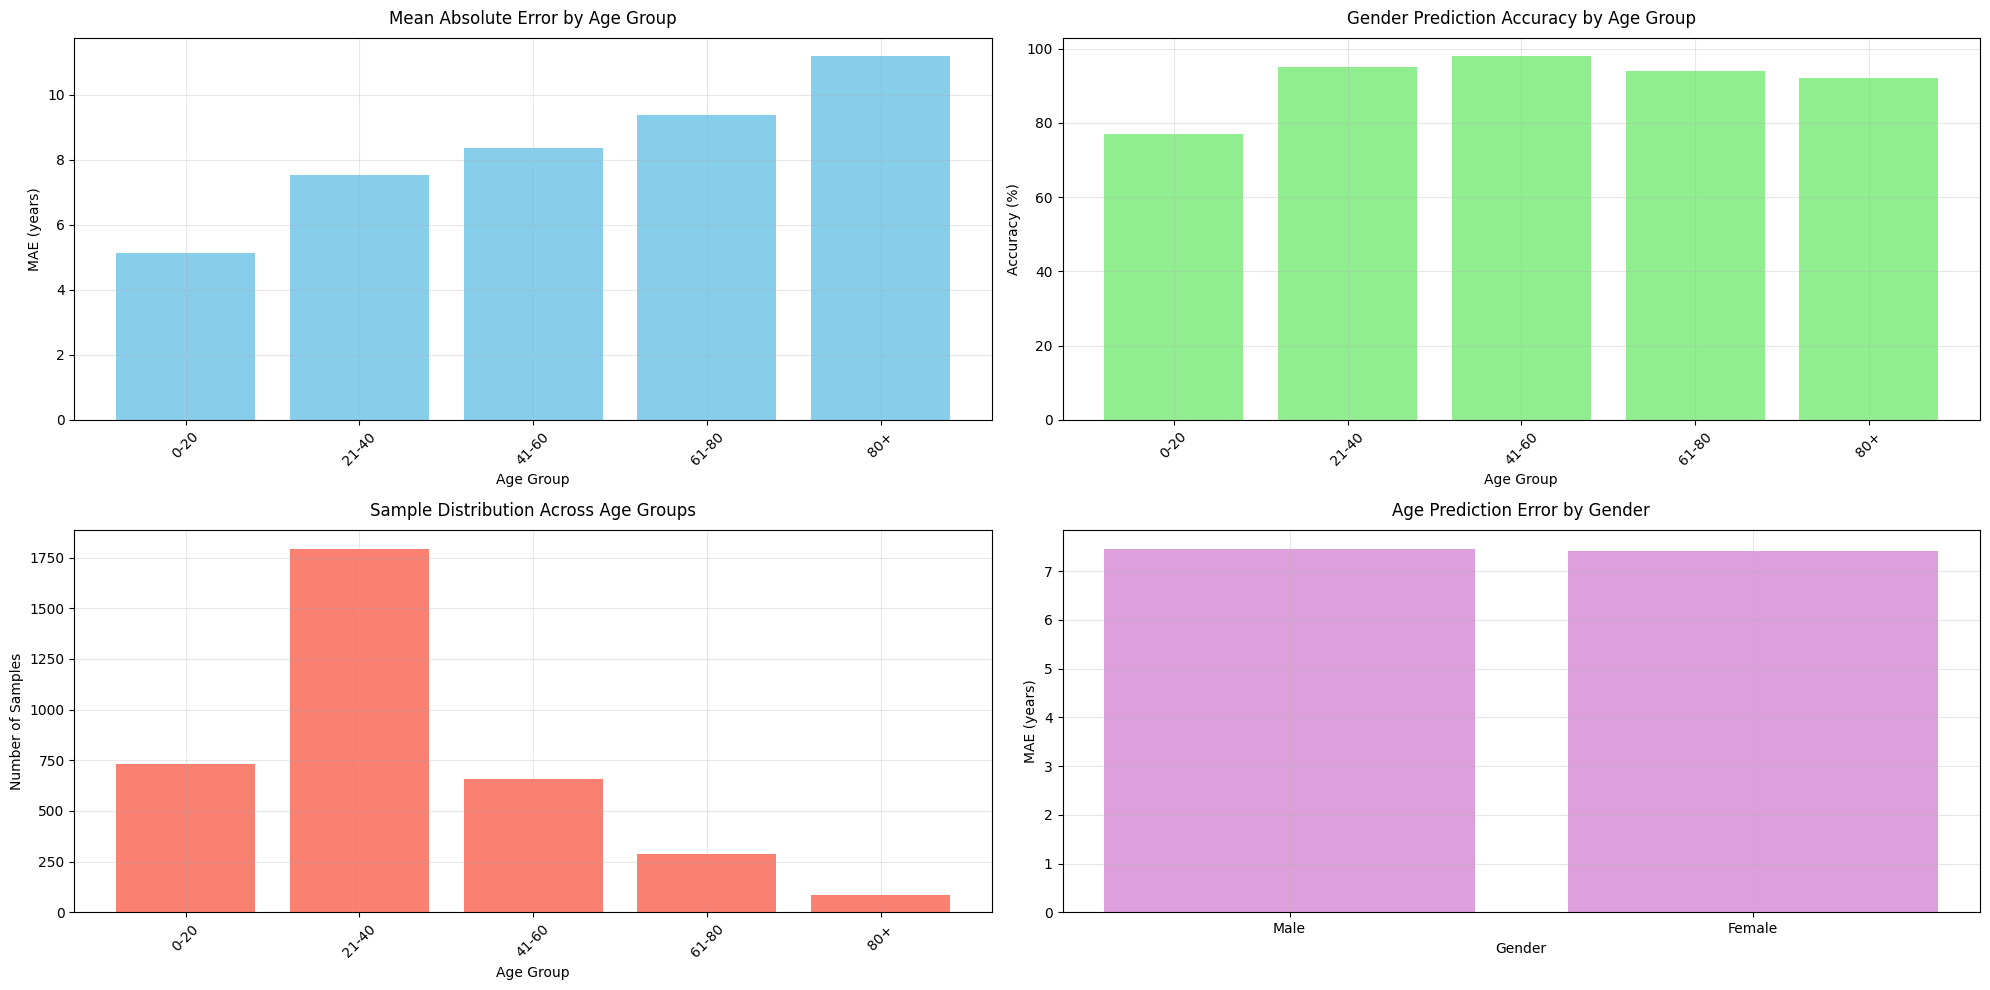


Detailed Performance Metrics:

Age Prediction MAE by Age Group:
age_true
0-20      5.13
21-40     7.54
41-60     8.35
61-80     9.39
80+      11.19
Name: age_pred, dtype: float32

Gender Prediction Accuracy by Age Group:
age_true
0-20     77.0
21-40    95.0
41-60    98.0
61-80    94.0
80+      92.0
Name: gender_pred, dtype: float64

Sample Distribution:
age_true
0-20      731
21-40    1794
41-60     658
61-80     288
80+        85
Name: age_true, dtype: int64

Age Prediction MAE by Gender:
gender_true
0    7.46
1    7.41
Name: age_pred, dtype: float32


In [13]:
# Plot detailed results
plot_detailed_results(age_bias, gender_bias)


## Analysis of results:

1. Model Architecture Performance:
- The training curve shows good convergence but some overfitting after epoch 10
- Final overall metrics are solid: 91.59% gender accuracy and 7.43 years MAE for age

2. Age Prediction Analysis:
- Clear age-dependent bias in accuracy:
  * Young (0-20): 5.13 years MAE
  * Middle-aged (21-40): 7.54 years MAE
  * Older (41-60): 8.35 years MAE
  * Elderly (61-80): 9.39 years MAE
  * Very elderly (80+): 11.19 years MAE
- The increasing MAE with age is particularly concerning for older populations
- Relatively balanced between genders (Male: 7.46, Female: 7.41 years MAE)

3. Gender Prediction Analysis:
- Strong performance variation across age groups:
  * Weakest for young people (0-20): 77% accuracy
  * Best for middle-aged (41-60): 98% accuracy
  * Remains robust for elderly: >90% accuracy
- Slight gender bias favoring females (93% vs 91% accuracy)

4. Dataset Distribution Issues:
- Severe imbalance across age groups:
  * 21-40 heavily overrepresented (1794 samples)
  * 80+ severely underrepresented (85 samples)
  * This explains some of the performance disparities

5. LIME Visualization Analysis:
- The model consistently focuses on:
  * Facial contours and jawline
  * Eye regions
  * Hair/hairline areas
- LIME visualizations suggest potential gender stereotyping in feature importance

Key Ethical Concerns:

1. Age-Related Biases:
- Significantly worse performance for elderly individuals
- Could lead to discrimination in age-sensitive applications
- Underrepresentation of elderly in training data

2. Gender Classification Issues:
- Lower accuracy for young people could affect gender-specific services
- Reliance on potentially stereotypical features for gender classification
- Binary gender classification might not be inclusive

3. Application Risks:
- Could perpetuate age discrimination in automated systems
- Risk of misgendering, particularly for younger individuals
- Potential for abuse in surveillance or profiling

Recommendations:

1. Technical Improvements:
- Implement age-specific loss weighting to address elderly bias
- Use data augmentation focusing on underrepresented groups
- Consider age group-specific models for better accuracy

2. Dataset Enhancements:
- Collect more data for elderly individuals
- Balance age group representation
- Include more diverse samples within each demographic

3. Deployment Guidelines:
- Avoid use in critical decision-making systems
- Implement confidence thresholds
- Require human oversight
- Provide clear accuracy limitations per demographic
- Regular bias monitoring and updates